# Import

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error, median_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc
import seaborn as sns
import matplotlib.pyplot as plt

# np.random.seed(42)

pd.set_option('display.max_columns', None)
rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)

import warnings
warnings.filterwarnings("ignore")


# Data


In [2]:
data5 = pd.read_excel('./于小鹏 机器学习5.xlsx')
data4 = pd.read_excel('./于小鹏 机器学习4 - 副本.xlsx')

In [3]:
data5

,总体生存时间,生存状态（编码）,feature_2,feature_3,feature_4,feature_5,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_26,feature_27,feature_28,TNM分期（编码汇总）,淋巴清扫
0,6.907895,0,0,1,58,1,1,5.68,51.20,43.10,3.20,42.30,1,19.00,14.90,42.10,11.9,1,2,2,0,3.2,1,0,1,0,1
1,18.519737,0,0,1,48,1,1,12.01,50.40,37.60,2.50,15.00,1,39.00,18.40,40.70,13.0,1,1,2,0,8.0,1,0,0,0,1
2,24.309210,0,0,2,76,0,1,8.99,52.10,37.00,1.70,1.80,0,19.00,14.00,41.90,12.6,1,1,1,0,5.1,1,0,1,0,1
3,9.440789,0,0,1,55,0,1,5.74,55.30,36.80,3.20,3.30,0,18.00,15.30,44.10,11.7,1,2,1,0,8.5,0,1,2,1,0
4,57.105263,1,0,1,51,1,1,9.02,60.30,32.80,3.70,2.10,0,12.00,14.40,41.00,10.9,1,2,2,0,4.7,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,11.233334,1,0,1,41,1,1,7.62,6.45,0.62,710.80,1.46,0,14.00,13.01,30.37,12.6,1,2,1,0,5.2,1,1,1,1,0
389,11.500000,1,1,1,59,1,2,2.28,1.34,0.58,280.30,3.29,0,50.61,49.94,34.89,18.7,2,2,1,1,4.0,1,0,2,1,0
390,16.000000,1,0,1,58,0,0,3.78,3.08,0.54,3.27,1.27,1,33.00,19.80,46.80,13.4,1,3,1,1,3.0,0,0,2,0,0
391,21.733334,1,1,2,54,0,1,6.39,5.39,0.49,2.17,338.00,1,9.00,11.67,37.73,14.0,1,2,1,0,9.0,1,0,2,1,0


In [4]:
data5.drop(["生存状态（编码）", "TNM分期（编码汇总）"], axis=1, inplace=True)
data5.describe()

,总体生存时间,feature_2,feature_3,feature_4,feature_5,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_26,feature_27,feature_28,淋巴清扫
count,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000
mean,27.167872,0.264631,1.470738,57.557252,0.277354,0.389313,6.580051,7.608880,2.987812,29.397628,10.537351,0.582697,40.784962,29.969389,40.751323,11.865929,1.111959,2.348601,1.096692,0.343511,5.371501,0.458015,0.157761,1.368957,0.692112
std,21.870527,0.441699,0.499779,9.819670,0.448263,0.587791,2.139456,13.980249,6.006594,133.323464,34.836997,0.493742,49.419389,58.302403,5.340986,1.529274,0.315718,0.587371,0.295915,0.475486,2.816180,0.498869,0.364981,0.587934,0.462208
min,1.500000,0.000000,1.000000,27.000000,0.000000,0.000000,2.280000,1.320000,0.150000,0.650000,0.200000,0.000000,6.000000,3.600000,24.400000,1.100000,1.000000,1.000000,1.000000,0.000000,0.700000,0.000000,0.000000,0.000000,0.000000
25%,10.733333,0.000000,1.000000,50.000000,0.000000,0.000000,5.110000,3.100000,1.210000,2.170000,1.560000,0.000000,17.000000,10.500000,37.600000,10.800000,1.000000,2.000000,1.000000,0.000000,3.000000,0.000000,0.000000,1.000000,0.000000
50%,22.000000,0.000000,1.000000,59.000000,0.000000,0.000000,6.300000,4.070000,1.580000,3.200000,2.890000,1.000000,25.000000,13.470000,41.200000,11.700000,1.000000,2.000000,1.000000,0.000000,5.000000,0.000000,0.000000,1.000000,1.000000
75%,38.000000,1.000000,2.000000,64.000000,1.000000,1.000000,7.650000,5.460000,2.030000,6.400000,5.240000,1.000000,41.000000,19.200000,44.000000,12.700000,1.000000,3.000000,1.000000,1.000000,7.000000,1.000000,0.000000,2.000000,1.000000
max,120.066667,1.000000,2.000000,83.000000,1.000000,2.000000,15.340000,87.200000,43.100000,1404.000000,338.000000,1.000000,370.000000,400.300000,78.300000,18.700000,2.000000,3.000000,2.000000,1.000000,17.000000,1.000000,1.000000,2.000000,1.000000


<AxesSubplot:xlabel='feature_14', ylabel='总体生存时间'>

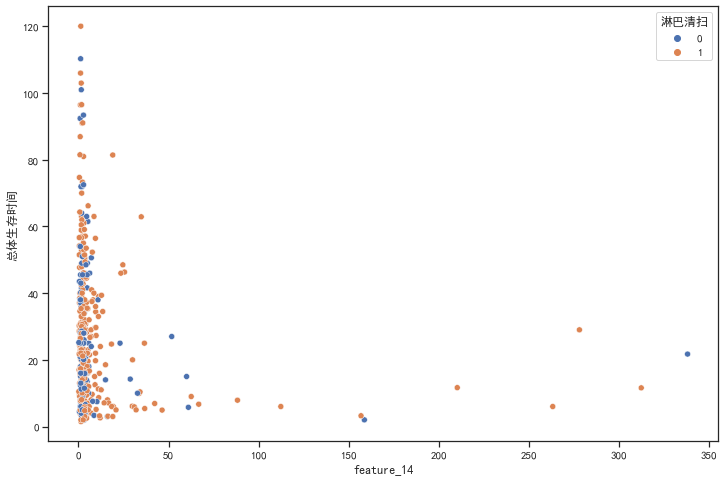

In [5]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=data5['feature_14'], y=data5['总体生存时间'], hue=data5['淋巴清扫'])

# preprocess

## feature selection

In [6]:
with_ftr = [
    "feature_25",
    "feature_20",
    "feature_2",
    "feature_21",
    "feature_14",
    "feature_15",
    "feature_7",
    "feature_13",
    "feature_26",
    "feature_24",
    "淋巴清扫",
    "TNM分期（编码汇总）",
    "总体生存时间",
]

without_ftr = [
    "feature_14",
    "feature_22",
    "feature_15",
    "feature_3",
    "feature_26",
    "feature_20",
    "feature_7",
    "feature_24",
    "feature_21",
    "feature_25",
    "淋巴清扫",
    "TNM分期（编码汇总）",
    "总体生存时间",
]


## Deal with raw data

In [7]:
def get_class(target):
    if target < 12:
        return 0
    elif target < 24:
        return 1
    elif target < 36:
        return 2
    elif target < 48:
        return 3
    elif target < 60:
        return 4
    else:
        return 5

data5['总体生存时间'] = data5['总体生存时间'].apply(get_class)

<AxesSubplot:>

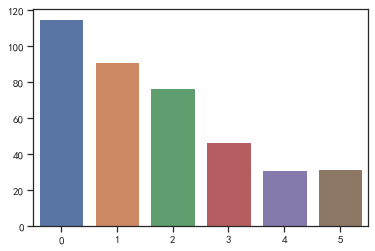

In [8]:
sns.barplot(y=data5['总体生存时间'].value_counts().values, x=data5['总体生存时间'].value_counts().index)

In [9]:
# # 11, 12, 13, 14, 15, 16, 17
df = data5.copy()
# abnormal = (df['feature_11'] > 20) | (df['feature_12'] > 15) | (df['feature_13'] > 1000) | (df['feature_14'] > 100) | (df['feature_15'] > 2500) | (df['feature_16'] > 200) | (df['feature_17'] > 100) | (df['feature_19'] < 2.5)
# df = df[~abnormal]

In [10]:
with_ = df[df['淋巴清扫'] == 1]
without_ = df[df['淋巴清扫'] == 0]

# with_ = pd.DataFrame(with_, columns=with_ftr)
# without_ = pd.DataFrame(without_, columns=without_ftr)

with_.drop(['淋巴清扫'], axis=1, inplace=True)
without_.drop(['淋巴清扫'], axis=1, inplace=True)

## Nomalization

In [11]:
scaler = StandardScaler()
# scaler = MinMaxScaler()

def scale(scaler, df):
    x = df.iloc[:, 0:].values
    y = df.iloc[:, 0].values
    
    x = scaler.fit_transform(x)
    # y = scaler.fit_transform(y.reshape(-1, 1))
    return x, y

In [12]:
with_x, with_y = scale(scaler, with_)
without_x, without_y = scale(scaler, without_)


## Split into training set and test set

In [13]:
with_train_x, with_valid_x, with_train_y, with_valid_y = train_test_split(with_x, with_y, test_size=0.1, random_state=1)
without_train_x, without_valid_x, without_train_y, without_valid_y = train_test_split(without_x, without_y, test_size=0.1, random_state=1)
with_train_x.shape, with_valid_x.shape


((244, 24), (28, 24))

In [14]:
without_train_x.shape, without_valid_x.shape

((108, 24), (13, 24))

# Model

In [15]:
def model_eval(model, x, y, valid_x, valid_y):
    model.fit(x, y)
    pred = model.predict(valid_x)
    proba = model.predict_proba(valid_x)
    
    acc = accuracy_score(valid_y, pred)
    precision = precision_score(valid_y, pred, average='macro')
    recall = recall_score(valid_y, pred, average='macro')
    f1 = f1_score(valid_y, pred, average='macro')

    auc = roc_auc_score(valid_y, proba, multi_class='ovo', labels=[0, 1, 2, 3, 4, 5])
    return acc, precision, recall, f1, auc

In [16]:
with_results = {}
without_results = {}

models = {
    # "LinearRegression": LinearRegression(),
    # "NeuralNetwork": MLPRegressor(max_iter=1000),
    # "DecisionTree": DecisionTreeRegressor(),
    # "SupportVectorMachine": SVR(),
    # "RandomForest": RandomForestRegressor(),
    # "KNeighbors": KNeighborsRegressor(),
    # "Ridge": Ridge(),
    # "Lasso": Lasso(),
    # "ElasticNet": ElasticNet(),
    "MLP": MLPClassifier(learning_rate="adaptive", max_iter=500),
    "SupportVectorMachine": SVC(probability=True),
    "RandomForest": RandomForestClassifier(),
    "KNeighbors": KNeighborsClassifier(),
}

for name, model in models.items():
    acc, precision, recall, f1, auc_ = model_eval(
        model,
        # with_.iloc[:, :-1],
        # with_.iloc[:, -1],
        # with_.iloc[:, :-1],
        # with_.iloc[:, -1],
        with_train_x,
        with_train_y,
        with_valid_x,
        with_valid_y
    )
    with_results[name] = [acc, precision, recall, f1, auc_]
for name, model in models.items():
    acc, precision, recall, f1, auc_ = model_eval(
        model,
        # without_.iloc[:, :-1],
        # without_.iloc[:, -1],
        # without_.iloc[:, :-1],
        # without_.iloc[:, -1],
        without_train_x,
        without_train_y,
        without_valid_x,
        without_valid_y
    )
    without_results[name] = [acc, precision, recall, f1, auc_]

# Results of classification

In [17]:
df1 = pd.DataFrame(with_results, index=['accuracy', 'precision', 'recall', 'f1_score', 'AUC'])
df1

,MLP,DecisionTree,SupportVectorMachine,RandomForest,KNeighbors
accuracy,0.678571,1.0,0.607143,0.821429,0.428571
precision,0.629630,1.0,0.680159,0.823611,0.286111
recall,0.607937,1.0,0.564683,0.786111,0.408730
f1_score,0.609758,1.0,0.548810,0.743386,0.315171
AUC,0.897965,1.0,0.937166,1.000000,0.836842


In [18]:
df2 = pd.DataFrame(without_results, index=['accuracy', 'precision', 'recall', 'f1_score', 'AUC'])
df2

,MLP,DecisionTree,SupportVectorMachine,RandomForest,KNeighbors
accuracy,0.538462,1.0,0.461538,0.923077,0.307692
precision,0.500000,1.0,0.330000,0.700000,0.266667
recall,0.600000,1.0,0.333333,0.800000,0.166667
f1_score,0.511111,1.0,0.320000,0.733333,0.200000
AUC,0.650000,1.0,0.775000,1.000000,0.702778


# Results of regression

In [19]:
# df1 = pd.DataFrame(with_results, index=['MSE', 'R2', 'EVS', 'MAE', 'MAE_'])
# df1

In [20]:
# df2 = pd.DataFrame(without_results, index=['MSE', 'R2', 'EVS', 'MAE', 'MAE_'])
# df2

# Plot

In [21]:
models

{'MLP': MLPClassifier(learning_rate='adaptive', max_iter=500),
 'DecisionTree': DecisionTreeClassifier(),
 'SupportVectorMachine': SVC(probability=True),
 'RandomForest': RandomForestClassifier(),
 'KNeighbors': KNeighborsClassifier()}

In [22]:
with_predictions = {}
without_predictions = {}

for name, model in models.items():
    model.fit(with_train_x, with_train_y)
    model.fit(without_train_x, without_train_y)
    w_pred = model.predict_proba(with_valid_x)
    wo_pred = model.predict_proba(without_valid_x)
    with_predictions[name] = w_pred
    without_predictions[name] = wo_pred

针对多类数据的ROC曲线的可视化方式有两种：

第一种为：采用将原始数据的真实类别标签矩阵和模型预测得到的概率矩阵分别按行展开，转置后形成两列，这就可以近似的看作获得了一个二分类的结果，进而可以可视化ROC曲线。

第二种方式为：将每类一类数据和其他类别的数据看作为一个二分类类的数据模型，然后对数据可视化ROC曲线。为了方便计算每一类样本的ROC曲线的相关取值，可以将类别标签使用label_binarize进行编码。

In [23]:
with_y_test = label_binarize(with_valid_y, classes=[0, 1, 2, 3, 4, 5]) # shape==(28, 3)
without_y_test = label_binarize(with_valid_y, classes=[0, 1, 2, 3, 4, 5]) # shape==(13, 3)

w_fpr = {}
w_tpr = {}
w_roc_auc = []
wo_fpr = {}
wo_tpr = {}
wo_roc_auc = []

for name, pred in with_predictions.items():
    w_fpr[name], w_tpr[name], _ = roc_curve(with_y_test.ravel(), pred.ravel())
    w_roc_auc.append(auc(w_fpr[name], w_tpr[name]))
    wo_fpr[name], wo_tpr[name], _ = roc_curve(without_y_test.ravel(), pred.ravel())
    wo_roc_auc.append(auc(wo_fpr[name], wo_tpr[name]))



In [24]:
def draw_roc(fpr, tpr, roc_auc, switch=True):
    plt.figure(figsize=(16, 10))
    lw = 2
    plt.plot(
        fpr["MLP"],
        tpr["MLP"],
        color='darkgrey',
        lw=lw,
        label="MLP_AUC (area = %0.2f)" % roc_auc[0],
    )
    plt.plot(
        fpr["DecisionTree"],
        tpr["DecisionTree"],
        color='peru',
        lw=lw,
        label="DecisionTree_AUC (area = %0.2f)" % roc_auc[1],
    )
    plt.plot(
        fpr["SupportVectorMachine"],
        tpr["SupportVectorMachine"],
        color='darkorange',
        lw=lw,
        label="SupportVectorMachine_AUC (area = %0.2f)" % roc_auc[2],
    )
    plt.plot(
        fpr["RandomForest"],
        tpr["RandomForest"],
        color='yellowgreen',
        lw=lw,
        label="RandomForest_AUC (area = %0.2f)" % roc_auc[3],
    )
    plt.plot(
        fpr["KNeighbors"],
        tpr["KNeighbors"],
        color='royalblue',
        lw=lw,
        label="KNeighbors_AUC (area = %0.2f)" % roc_auc[4],
    )
    plt.plot([0, 1], [0, 1], color="violet", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    if switch:
        plt.title(f"ROC Curve of Different Models（清扫组）")
    else:
        plt.title("ROC Curve of Different Models（未清扫组）")
    plt.legend(loc="lower right")
    plt.show()

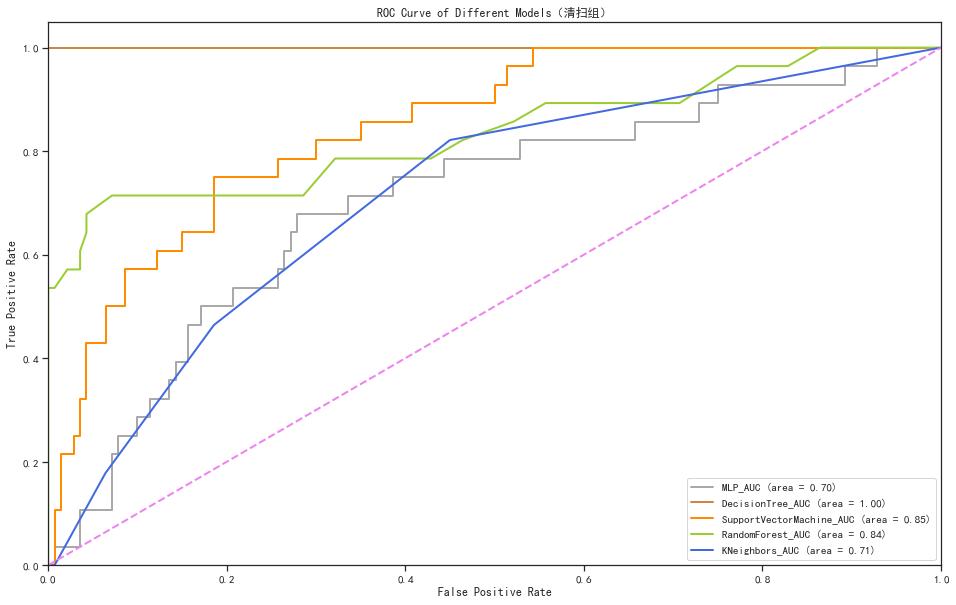

In [25]:
draw_roc(w_fpr, w_tpr, w_roc_auc)

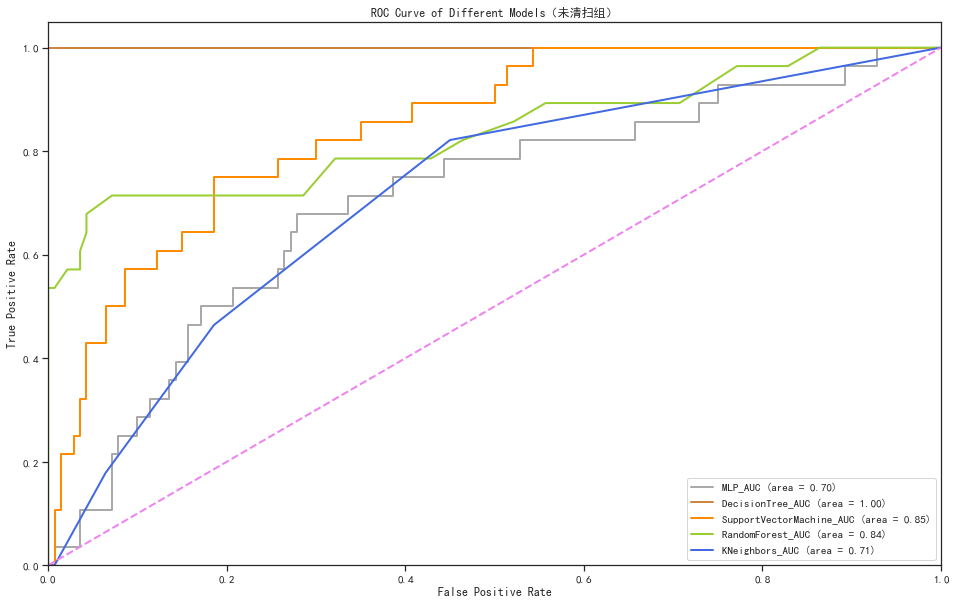

In [26]:
draw_roc(wo_fpr, wo_tpr, wo_roc_auc, switch=False)